## Import des bibiliothèques

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl

from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [96]:
def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_facecolor().ravel()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)


## Préparation du jeu de données

In [97]:
# importer données du fichier csv
bigfoot = pd.read_csv("./data/bigfoot.csv", sep = ",")

In [98]:
bigfoot = bigfoot[bigfoot.classification != "Class C"]

In [99]:
# ajoute des colonnes jour, mois, année
year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in bigfoot['date'].index:
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = d_datetime.month
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius
# wind_speed : miles par heure en kilomètre par heure
# precip_intensity : inch en cm
# visibility : miles en kilomètre
# latitude / longitude : coordonnées polaires
bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    wind_speed = bigfoot.wind_speed * 1.609344,
    precip_intensity = bigfoot.precip_intensity * 2.54,
    visibility = bigfoot.visibility * 1.609344,
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”
bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

# transformation de precip_type en deux colonnes snow et rain
# transformation de season en quatre colonnes
bigfoot["rain"] = 0.0
bigfoot.loc[bigfoot.precip_type == "rain", "rain"] = 1.0
bigfoot["snow"] = 0.0
bigfoot.loc[bigfoot.precip_type == "snow", "snow"] = 1.0
bigfoot["summer"] = 0.0
bigfoot.loc[bigfoot.season == "Summer", "summer"] = 1.0
bigfoot["spring"] = 0.0
bigfoot.loc[bigfoot.season == "Spring", "spring"] = 1.0
bigfoot["fall"] = 0.0
bigfoot.loc[bigfoot.season == "Fall", "fall"] = 1.0
bigfoot["winter"] = 0.0
bigfoot.loc[bigfoot.season == "Winter", "winter"] = 1.0

bigfoot.drop(columns="geohash", inplace=True)
bigfoot.drop(columns="date", inplace=True)
bigfoot.drop(columns=["precip_type"], inplace=True)

C:\Users\Aurelie\AppData\Local\Temp\ipykernel_14884\2109029672.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
  title = bigfoot.title.str.replace(r'^Report \d*: ', '')


### Typage des variables

In [100]:
# dictionnaire des états des Etats-Unis et leur abbrévation
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

# variables catégorielles
# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.
bigfoot.county = pd.Categorical(bigfoot.county)
bigfoot.state = pd.Categorical(bigfoot.state, categories=us_state_to_abbrev.keys())
bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B"], ordered=True)

bigfoot.observed = bigfoot.observed.astype('str')
bigfoot.location_details = bigfoot.location_details.astype('str')
bigfoot.title = bigfoot.title.astype('str')
bigfoot.summary = bigfoot.summary.astype('str')
bigfoot.number = bigfoot.number.astype('Int64')
bigfoot.day = bigfoot.day.astype(float)
bigfoot.month = bigfoot.month.astype(float)
bigfoot.year = bigfoot.year.astype(float)

### Observer les corrélations pour supprimer des variables

In [101]:
bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point"], inplace=True)

features = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

cat_cols = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
]

num_cols = [
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
]

## Apprentissage non-supervisé

#### Transformations pré-ACP

In [102]:
def fill_missing(df):
    '''
    replace empty values by column's mean in dataframe
    '''
    return df.copy().fillna(df.mean())

In [103]:
def calculate_zscore(df):
    '''
    scales columns in dataframe using z-score
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

    return df

In [104]:
def normalize_column_modality(df):
    '''
    divides each column by the probability μₘ of the modality 
    (number of ones in the column divided by N) only for one hot columns
    '''
    df = df.copy()
    length = len(df)
    for col in df.columns:
        weight = math.sqrt(sum(df[col])/length)
        df[col] = df[col]/weight

    return df

In [105]:
# Dealing with missing values
bigfoot[["latitude", "longitude"]] = bigfoot[["latitude", "longitude"]].fillna(bigfoot.groupby('state')[["latitude", "longitude"]].transform('mean'))
bigfoot = bigfoot.assign(
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)
bigfoot[["day", "month", "year"]] = bigfoot[["day", "month", "year"]].fillna(bigfoot.groupby('season')[["day", "month", "year"]].transform('median'))
bigfoot.head()

,observed,location_details,county,state,season,title,latitude,longitude,number,classification,...,month,day,r,theta,rain,snow,summer,spring,fall,winter
0,I was canoeing on the Sipsey river in Alabama....,nan,Winston County,Alabama,Summer,nan,33.071369,-86.653602,30680,B,...,7.0,15.0,92.749998,2.777004,0.0,0.0,1.0,0.0,0.0,0.0
1,Ed L. was salmon fishing with a companion in P...,East side of Prince William Sound,Valdez-Chitina-Whittier County,Alaska,Fall,nan,60.167644,-142.750109,1261,A,...,10.0,15.0,154.912036,2.742699,0.0,0.0,0.0,0.0,1.0,0.0
2,"While attending U.R.I in the Fall of 1974,I wo...","Great swamp area, Narragansett Indians",Washington County,Rhode Island,Fall,Bicycling student has night encounter,41.450000,-71.500000,6496,A,...,9.0,20.0,82.645947,2.616218,0.0,0.0,0.0,0.0,1.0,0.0
3,"Hello, My name is Doug and though I am very re...",I would rather not have exact location (listin...,York County,Pennsylvania,Summer,nan,40.897262,-78.282861,8000,B,...,7.0,15.0,88.322095,2.660163,0.0,0.0,1.0,0.0,0.0,0.0
4,It was May 1984. Two friends and I were up in ...,"Logging roads north west of Yamhill, OR, about...",Yamhill County,Oregon,Spring,nan,44.423294,-122.125632,703,B,...,5.0,15.0,129.954219,2.792721,0.0,0.0,0.0,1.0,0.0,0.0


In [106]:
bigfoot_famd_num = pd.DataFrame(calculate_zscore(fill_missing(bigfoot[num_cols])))
bigfoot_famd_cat = normalize_column_modality(bigfoot[cat_cols])
bigfoot_famd = pd.concat([bigfoot_famd_num, bigfoot_famd_cat], axis=1)
bigfoot_famd

,r,theta,latitude,temperature_mid,humidity,cloud_cover,moon_phase,precip_intensity,precip_probability,pressure,...,wind_speed,year,month,day,summer,winter,fall,spring,rain,snow
0,-0.747332,0.439927,-1.181498,-6.181748e-14,-1.791778e-13,5.228035e-14,1.729988e-14,3.309073e-15,3.085056e-14,6.439038e-12,...,-1.002473e-14,0.248445,-0.067941,0.069109,1.639411,0.0,0.00000,0.000000,0.0,0.0
1,2.942550,-0.123299,3.724751,-6.181748e-14,-1.791778e-13,5.228035e-14,1.729988e-14,3.309073e-15,3.085056e-14,6.439038e-12,...,-1.002473e-14,0.248445,0.952401,0.069109,0.000000,0.0,1.83267,0.000000,0.0,0.0
2,-1.347099,-2.199884,0.335598,1.192347e+00,1.170190e+00,1.610229e+00,-1.424402e+00,-1.547490e-01,-9.621950e-01,7.937814e-01,...,1.136091e+00,-1.930530,0.612287,0.716726,0.000000,0.0,1.83267,0.000000,0.0,0.0
3,-1.010168,-1.478392,0.235515,-6.181748e-14,-1.791778e-13,5.228035e-14,1.729988e-14,3.309073e-15,3.085056e-14,6.439038e-12,...,-1.002473e-14,0.248445,-0.067941,0.069109,1.639411,0.0,0.00000,0.000000,0.0,0.0
4,1.461077,0.697957,0.873964,-6.181748e-14,-1.791778e-13,5.228035e-14,1.729988e-14,3.309073e-15,3.085056e-14,6.439038e-12,...,-1.002473e-14,0.323582,-0.748169,0.069109,0.000000,0.0,0.00000,2.467101,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,0.453107,1.140129,-0.697278,-6.181748e-14,-1.791778e-13,5.228035e-14,1.729988e-14,3.309073e-15,3.085056e-14,6.439038e-12,...,-1.002473e-14,0.248445,-0.067941,0.069109,1.639411,0.0,0.00000,0.000000,0.0,0.0
5017,-1.131468,-1.316551,-0.072657,-6.181748e-14,-1.791778e-13,5.228035e-14,1.729988e-14,3.309073e-15,3.085056e-14,6.439038e-12,...,-1.002473e-14,0.323582,-0.748169,0.069109,0.000000,0.0,0.00000,2.467101,0.0,0.0
5018,-1.085451,0.919268,-1.981543,-6.181748e-14,-1.791778e-13,5.228035e-14,1.729988e-14,3.309073e-15,3.085056e-14,6.439038e-12,...,-1.002473e-14,0.248445,-0.067941,0.069109,1.639411,0.0,0.00000,0.000000,0.0,0.0
5019,-0.452832,-0.466601,0.041410,-6.181748e-14,-1.791778e-13,5.228035e-14,1.729988e-14,3.309073e-15,3.085056e-14,6.439038e-12,...,-1.002473e-14,0.248445,0.952401,0.069109,0.000000,0.0,1.83267,0.000000,0.0,0.0


#### ACP

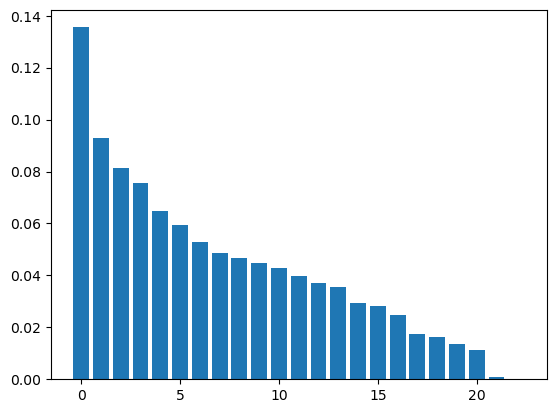

In [107]:
cls_PCA = PCA()
pcs = cls_PCA.fit_transform(bigfoot_famd)
plt.bar(range(cls_PCA.components_.shape[0]), cls_PCA.explained_variance_ratio_)
plt.show()

Avec la technique du coude, il semblerait qu'on ait besoin de 8 composantes pour représenter nos données. Cela donnerait 61% de variance expliquée au total. C'est pas folichon...

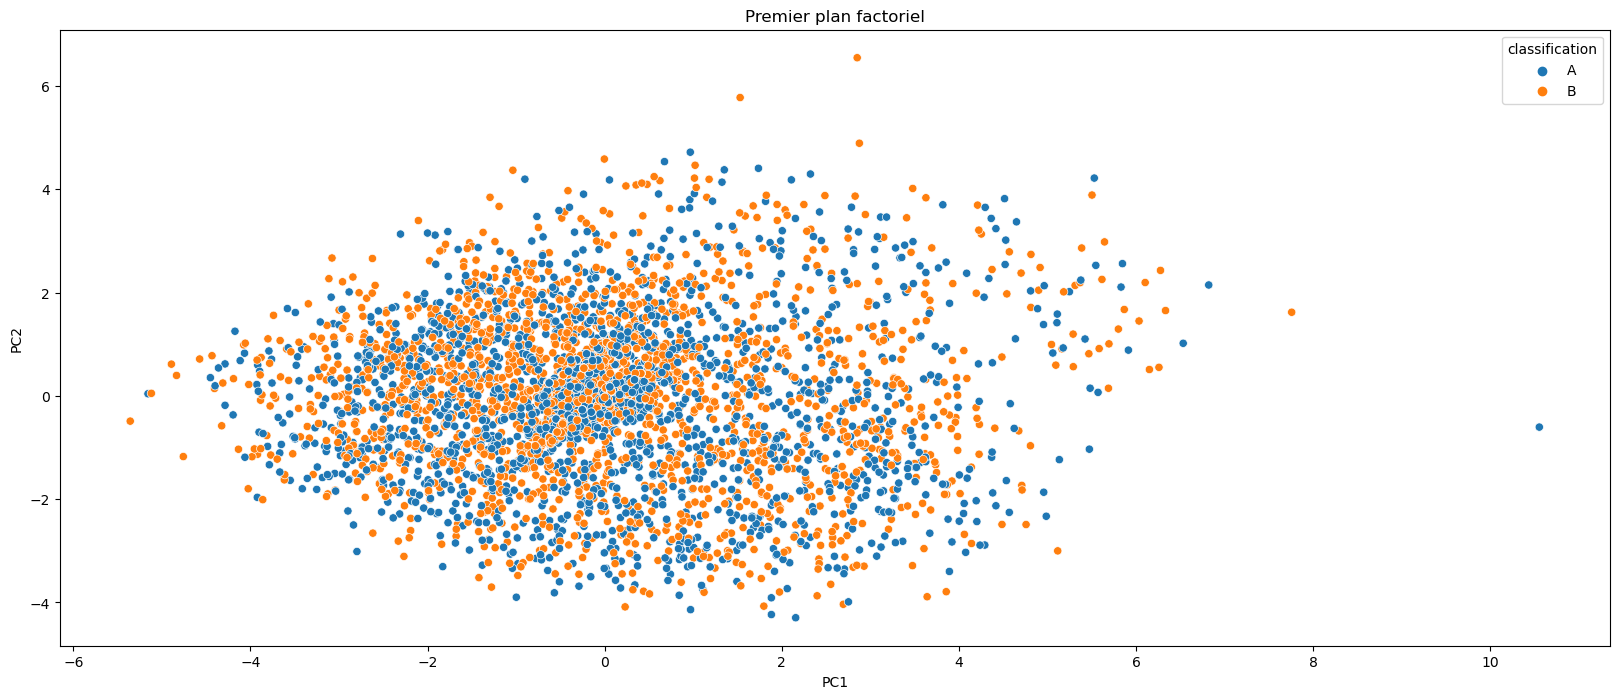

In [108]:
plt.figure(figsize=(20,8))
df_X = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(cls_PCA.components_.shape[0])])
sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X)
plt.title("Premier plan factoriel")
plt.show()

In [109]:
df_X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,-0.586809,-0.661897,0.559198,-0.425275,0.450725,0.198681,-0.283355,0.472546,-0.656137,-0.119800,...,-0.245541,0.883167,-0.405023,0.712017,0.041242,-0.494063,-0.238671,-0.375400,-0.017466,-0.059948
1,0.497348,2.227936,-3.457672,1.215146,-1.274762,0.543125,-0.155003,-0.494915,1.120050,0.175633,...,0.479077,-0.662457,-0.240393,-1.449340,0.147166,0.623451,0.210742,-0.609042,0.010790,-0.189235
2,2.008815,-1.310306,-0.030019,-2.619903,-1.625166,-1.295178,-1.965444,0.150174,1.481936,-1.107183,...,0.620420,-0.257338,-1.001645,-0.791263,0.337287,0.845396,0.511657,0.134111,-0.065050,0.221379
3,-0.043186,-0.423424,0.629280,-0.467401,-1.621544,0.247789,-0.635879,0.317172,-0.124273,0.077217,...,-0.085538,0.603110,-0.114663,0.559644,-0.015628,-0.280804,-0.068710,-0.391959,-0.011803,0.046149
4,-0.200046,0.736961,-0.021136,2.038265,0.353313,0.441301,0.245403,-1.218572,1.049025,0.096573,...,0.222614,0.240667,-0.131806,-0.352554,-0.517958,0.069992,0.287307,-0.507364,-0.008971,0.032068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986,-0.653329,-0.140941,-0.289777,0.384275,0.994178,0.387418,-0.388292,0.413092,-0.560051,-0.158439,...,-0.241974,0.792008,-0.579607,0.416840,0.019741,-0.416701,-0.170787,-0.406874,-0.014913,0.027094
4987,0.043401,-0.381726,1.883305,0.226942,-1.224033,0.029291,0.416663,-1.112753,0.927670,0.217057,...,0.242869,0.394063,0.308980,0.280977,-0.479616,-0.065107,0.163703,-0.442603,-0.014466,0.066125
4988,-0.783000,-0.966199,0.867528,-0.729316,1.082742,0.103659,-0.097562,0.559892,-0.912143,-0.185165,...,-0.312428,1.033854,-0.454411,0.892144,0.073154,-0.612102,-0.335708,-0.356719,-0.020989,-0.087913
4989,0.057896,0.174288,-0.668959,-1.473315,-0.589826,-0.155817,0.628899,-0.102257,0.143540,0.065213,...,0.271877,-0.013390,-0.002060,-0.257368,0.290517,0.100730,-0.232473,-0.488938,-0.006923,-0.049091


In [110]:
df_classification = pd.DataFrame(bigfoot.classification, columns = ["classification"])

In [111]:
df_classification.reset_index(drop=True)

,classification
0,B
1,A
2,A
3,B
4,B
...,...
4986,B
4987,A
4988,A
4989,B


In [112]:
df_X_classification = pd.concat([df_X.reset_index(drop=True), df_classification.reset_index(drop=True)], axis=1)

In [113]:
df_X_classification

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,classification
0,-0.586809,-0.661897,0.559198,-0.425275,0.450725,0.198681,-0.283355,0.472546,-0.656137,-0.119800,...,0.883167,-0.405023,0.712017,0.041242,-0.494063,-0.238671,-0.375400,-0.017466,-0.059948,B
1,0.497348,2.227936,-3.457672,1.215146,-1.274762,0.543125,-0.155003,-0.494915,1.120050,0.175633,...,-0.662457,-0.240393,-1.449340,0.147166,0.623451,0.210742,-0.609042,0.010790,-0.189235,A
2,2.008815,-1.310306,-0.030019,-2.619903,-1.625166,-1.295178,-1.965444,0.150174,1.481936,-1.107183,...,-0.257338,-1.001645,-0.791263,0.337287,0.845396,0.511657,0.134111,-0.065050,0.221379,A
3,-0.043186,-0.423424,0.629280,-0.467401,-1.621544,0.247789,-0.635879,0.317172,-0.124273,0.077217,...,0.603110,-0.114663,0.559644,-0.015628,-0.280804,-0.068710,-0.391959,-0.011803,0.046149,B
4,-0.200046,0.736961,-0.021136,2.038265,0.353313,0.441301,0.245403,-1.218572,1.049025,0.096573,...,0.240667,-0.131806,-0.352554,-0.517958,0.069992,0.287307,-0.507364,-0.008971,0.032068,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986,-0.653329,-0.140941,-0.289777,0.384275,0.994178,0.387418,-0.388292,0.413092,-0.560051,-0.158439,...,0.792008,-0.579607,0.416840,0.019741,-0.416701,-0.170787,-0.406874,-0.014913,0.027094,B
4987,0.043401,-0.381726,1.883305,0.226942,-1.224033,0.029291,0.416663,-1.112753,0.927670,0.217057,...,0.394063,0.308980,0.280977,-0.479616,-0.065107,0.163703,-0.442603,-0.014466,0.066125,A
4988,-0.783000,-0.966199,0.867528,-0.729316,1.082742,0.103659,-0.097562,0.559892,-0.912143,-0.185165,...,1.033854,-0.454411,0.892144,0.073154,-0.612102,-0.335708,-0.356719,-0.020989,-0.087913,A
4989,0.057896,0.174288,-0.668959,-1.473315,-0.589826,-0.155817,0.628899,-0.102257,0.143540,0.065213,...,-0.013390,-0.002060,-0.257368,0.290517,0.100730,-0.232473,-0.488938,-0.006923,-0.049091,B


## Méthodes arborescentes

### DecisionTreeClassifier

In [114]:
X = df_X_classification[["PC1","PC2"]]
y = df_X_classification.iloc[:, -1]
cls = DecisionTreeClassifier()
cls.fit(X, y)

DecisionTreeClassifier()

C:\Users\Aurelie\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


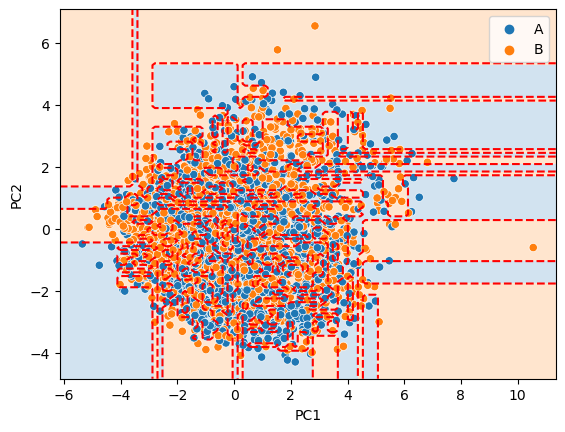

In [115]:
sns.scatterplot(x="PC1", y="PC2", hue="classification", data=df_X_classification)
add_decision_boundary(cls)
plt.show()

In [116]:
print(cls.get_depth())
print(cls.get_n_leaves())

52
1646


In [117]:
X_train, X_test, y_train, y_test = train_test_split(df_X_classification[["PC1","PC2"]], df_X_classification[["classification"]], train_size=0.66)

clf = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.5279905715969357
